In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import scipy.stats as sps

from collections import OrderedDict

In [2]:
import elfi

In [3]:
from abc_reconstruction.model import Model
from abc_reconstruction.utils import PriorPosition  #, cart_to_pol, pol_to_cart
from abc_reconstruction.prior import BoundedNormal_x, BoundedNormal_y

You don't have ROOT or root_pandas, root truth file output is disabled


# Init model

In [4]:
model = Model('XENON1T_ABC.ini')  #, coordinate_system = 'polar')

In [5]:
model.change_defaults(s2_electrons = 25)

In [6]:
prior_mean = PriorPosition()

In [7]:
true_pos = np.loadtxt('data/truepos')

# Select pattern to reconstruct

In [8]:
# The true position of the hitpattern
truth = true_pos[0]
print(truth)

[  2.62643434 -17.96082368]


In [9]:
#cart_to_pol(*true_pos[0])

In [10]:
# The hitpattern to reconstruct
#data = model(*cart_to_pol(*true_pos[0]))
data = model(*truth)
# What pax thinks of this hitpattern
pax_pos = model.get_latest_pax_position()
# The prior mean (not used)
prior_pos = prior_mean(data) 

In [11]:
pax_pos

{'PosRecNeuralNet': {'x': 2.7636165889574635, 'y': -16.868604536756052},
 'PosRecTopPatternFit': {'x': 2.867794486215537, 'y': -17.580827067669176}}

In [12]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [13]:
#prior_pos_pol = cart_to_pol(*prior_pos)

# Build ELFI Priors

In [14]:
r_bound = 47.9

In [15]:
prior_pos

(4.115222817130077, -15.358220637996187)

In [16]:
px = elfi.Prior(BoundedNormal_x, r_bound, prior_pos, 64)
py = elfi.Prior(BoundedNormal_y, px, r_bound, prior_pos, 64)

## Get PMT mask

In [17]:
pmt_mask = model.pmt_mask[:127].astype(int)

In [18]:
pmt_mask

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Build BOLFI Model

In [19]:
model=elfi.tools.vectorize(model)

In [20]:
Y = elfi.Simulator(model, px, py, observed=data)

In [21]:
# Test calling FM
#elfi.Simulator.generate(Y)

## Define Distance functions

In [22]:
def likelihood_chisquare(y, n, w=None):
    if w is not None:
        y = y[:,w.astype(bool)]
        n = n[:,w.astype(bool)]

    n = np.clip(n, 1e-5, None)
    y = np.clip(y, 1e-5, None)
    res = 2 * np.sum(y - n  + n * np.log(n/y), axis=1)
    lres = np.log(res)
    if lres > 10:
        lres = np.ones(lres.shape) * 9
    return lres

In [23]:
from functools import partial

In [24]:
likelihood_chisquare_masked = partial(likelihood_chisquare, w=pmt_mask)

In [25]:
d = elfi.Distance('euclidean', Y, w=pmt_mask)
log_d = elfi.Operation(np.log, d)

# Distance cannot take weigths kwarg when passing callable instead of string, using functools instead
#log_d = elfi.Distance(likelihood_chisquare_masked, Y)

In [26]:
# Check Summary stat
#elfi.Simulator.generate(d)
#elfi.Simulator.generate(log_d)

In [27]:
# Load modified minimize function which we can pass different minimizer method and constraint.
from abc_reconstruction.utils import minimize
from abc_reconstruction.utils import ConstraintLCBSC

In [28]:
from elfi.methods.bo.gpy_regression import GPyRegression
from elfi.methods.utils import ModelPrior

In [29]:
bounds = {'px':(-r_bound, r_bound), 'py':(-r_bound, r_bound)} 

In [30]:
# Define the default GP target model
target_model = GPyRegression(log_d.model.parameter_names, bounds=bounds)

# Define the custom acquisition method
acquisition_method = ConstraintLCBSC(target_model,
                                     prior = ModelPrior(log_d.model),
                                     noise_var = [0.01, 0.01],  # [0.1, 0.1],
                                     exploration_rate = 10,
                                     #seed=self.seed  # Use np.random
                                    )

In [31]:
bolfi = elfi.BOLFI(log_d, batch_size=1, initial_evidence=20, update_interval=1,
                   #bounds=bounds,  # Not used when using target_model
                   target_model = target_model,
                   acquisition_method = acquisition_method,
                   #acq_noise_var=[0.1, 0.1],  # Not used when using acquisition_method
                   #async=True,  # Could we use this?
                  )

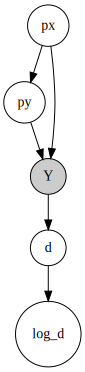

In [32]:
elfi.draw(px)

# Fit GP model

In [33]:
%time post = bolfi.fit(n_evidence=200)

CPU times: user 8min 11s, sys: 11min 43s, total: 19min 54s
Wall time: 3min 10s


In [34]:
# Test animation
#for b in range(1, 200):
#bolfi.set_objective(n_evidence=200)  # b
#bolfi.iterate()  # Calls update()
#bolfi.plot_state()
#    plt.savefig('bolfi_surface_%03d.png' % b, dpi=150)
#bolfi.infer(n_evidence=100, vis=dict(xlim=(-r_bound, r_bound), ylim=(-r_bound, r_bound)))

In [35]:
bolfi.target_model


Name : GP regression
Objective : -9.556830952985479
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |    priors  
  sum.rbf.variance         |  0.048287283478150304  |      +ve      |  Ga(2.4, 1)
  sum.rbf.lengthscale      |     5.060912051405406  |      +ve      |  Ga(32, 1) 
  sum.bias.variance        |     3.231367822209403  |      +ve      |  Ga(0.6, 1)
  Gaussian_noise.variance  |  0.017867566744636965  |      +ve      |            

<Figure size 432x288 with 0 Axes>

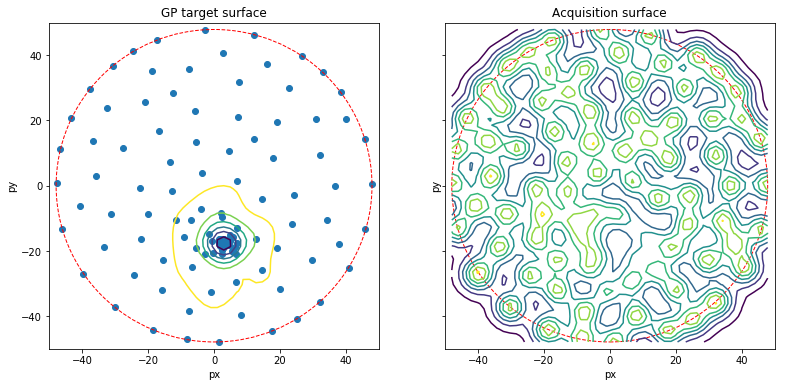

In [36]:
bolfi.plot_state()
plt.xlim(-50, 50)
plt.ylim(-50, 50)
for ax in plt.gcf().axes:
    ax.add_artist(plt.Circle((0,0), 47.9, color='red', fill=False, linestyle='--'))
#plt.savefig('surface_constraint_edge.png', dpi=150)
#plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f370a9edef0>,
      dtype=object)

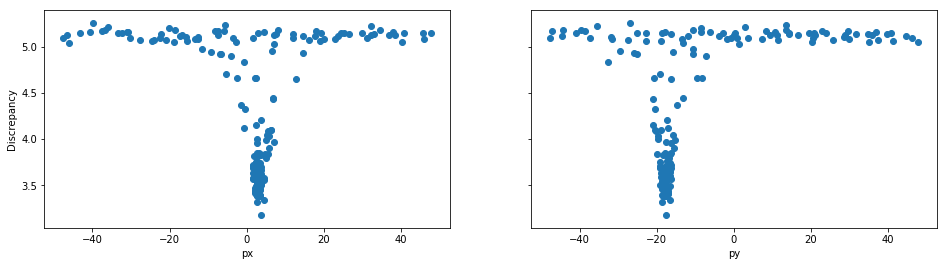

In [37]:
bolfi.plot_discrepancy()
#plt.savefig('euclidean_edge.png', dpi=150)

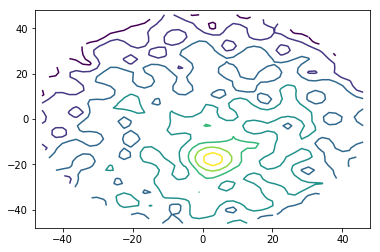

In [48]:
post.plot(logpdf=True)

# Sample from GP model

In [39]:
%time result_BOLFI = bolfi.sample(1000, info_freq=1000)

4 chains of 1000 iterations acquired. Effective sample size and Rhat for each parameter:
px 2687.7681926421583 1.0012662342705272
py 2841.458825808093 0.9995368110681052
CPU times: user 1min 48s, sys: 1min 30s, total: 3min 19s
Wall time: 49.4 s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f370add2f28>,
      dtype=object)

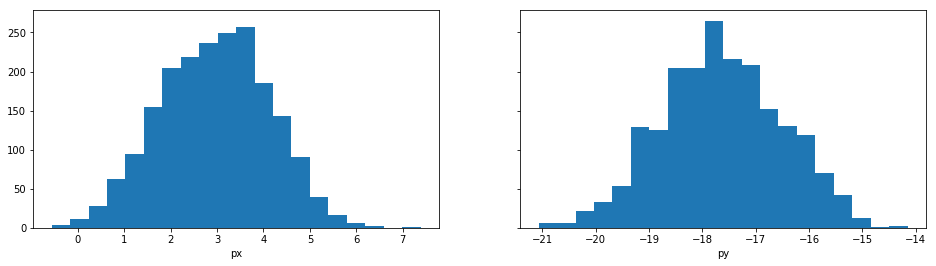

In [40]:
result_BOLFI.plot_marginals()

In [42]:
res = OrderedDict()
res['mean'] = [result_BOLFI.sample_means['px'], result_BOLFI.sample_means['py']]
res['median'] = bolfi_median = np.median(result_BOLFI.samples_array, axis=0)
res['mode'] = sps.mode(result_BOLFI.samples_array).mode[0]
res['truth'] = truth
res['tpf'] = [pax_pos['PosRecTopPatternFit']['x'], pax_pos['PosRecTopPatternFit']['y']]
res['nn'] = [pax_pos['PosRecNeuralNet']['x'], pax_pos['PosRecNeuralNet']['y']]

for k, v in res.items():
    if k == 'truth':
        print('%s:\t x=%.2f cm,\t y=%.2f cm' % (k, v[0], v[1]))
    else:
        d = ((truth[0] - v[0])**2 + (truth[1] -  v[1])**2)**0.5
        print('%s:\t x=%.2f cm,\t y=%.2f cm,\t d_truth=%.2f cm' % (k, v[0], v[1], d))


mean:	 x=2.96 cm,	 y=-17.63 cm,	 d_truth=0.47 cm
median:	 x=3.00 cm,	 y=-17.66 cm,	 d_truth=0.48 cm
mode:	 x=3.27 cm,	 y=-17.58 cm,	 d_truth=0.74 cm
truth:	 x=2.63 cm,	 y=-17.96 cm
tpf:	 x=2.87 cm,	 y=-17.58 cm,	 d_truth=0.45 cm
nn:	 x=2.76 cm,	 y=-16.87 cm,	 d_truth=1.10 cm
